# Compare SVD analysis with PixelFLipping scores

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

device = "cpu"
MNIST_CNN_PATH = './models/'
data_dir = "./dataset"
cat16_dir = data_dir + "/cat16"

import os
from tqdm.notebook import tqdm
import copy
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

import quantus

from util.util_cnn import CNNModel, data_loaders, test, \
                params_to_filename, params_from_filename

from util.util_gamma_rule import \
                forw_surrogate_matrix,  \
                back_matrix, \
                global_conv_matrix_from_pytorch_layer, \
                calc_evals_batch, \
                calc_vals_batch, \
                plot_evals_lineplot, \
                smart_gamma_wo_sign_flips, \
                col_norms_for_matrices

from util.util_gamma_layers import GammaPerNeuronLayer, GammaWoSignFlipsLayer, Conv2dAsMatrixLayer

from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain
from util.util_data_summary import *
import util.util_tutorial as tut_utils

from util.naming import *
from util.util_pickle import *

### Load models

In [2]:
model = CNNModel().to(device)
model.load_state_dict(torch.load('./models/mnist_cnn_v4_cb1-16_cb2-32_seed-0.torch'))

<All keys matched successfully>

In [3]:
# load v4 models
model_dict = {}
for fn in os.listdir(MNIST_CNN_PATH):
    if 'mnist_cnn_v4' in fn:
        params = params_from_filename(fn)
        cnn_model = CNNModel(*params).to(device)
        cnn_model.load_state_dict(torch.load(os.path.join(MNIST_CNN_PATH, fn)))
        model_dict[fn[13:-6]] = cnn_model

In [4]:
ll =list(model_dict.keys())
ll.sort()
ll

['cb1-16-16_cb2-32-32_seed-0',
 'cb1-16_cb2-32_seed-0',
 'cb1-16_cb2-32_seed-1',
 'cb1-16_cb2-32_seed-2',
 'cb1-16_cb2-32_seed-3',
 'cb1-8-8-8_cb2-16-16-16_seed-0',
 'cb1-8-8-8_cb2-16-16-16_seed-1',
 'cb1-8-8-8_cb2-16-16-16_seed-2',
 'cb1-8-8-8_cb2-16-16-16_seed-3',
 'cb1-8-8_cb2-16-16_seed-0',
 'cb1-8-8_cb2-16-16_seed-1',
 'cb1-8-8_cb2-16-16_seed-2',
 'cb1-8-8_cb2-16-16_seed-3',
 'cb1-8_cb2-16_seed-0',
 'cb1-8_cb2-16_seed-1',
 'cb1-8_cb2-16_seed-2',
 'cb1-8_cb2-16_seed-3']

In [5]:
models_1 = {k:v for (k,v) in model_dict.items() if 'cb1-8' in k and 'seed-0' in k}

In [6]:
model_d3 = model_dict['cb1-8-8-8_cb2-16-16-16_seed-0']

### Load data

In [8]:
train_loader, test_loader = data_loaders()

for i, (data, target) in enumerate(test_loader):
    break

### Forward pass, define LRP modes, LRP abckward passes

In [8]:
for i, l in enumerate(layers):
    print(i, "Input:", list(A[i].shape), '->', str(l).split('(')[0],
    (list(l.weight.shape)) if isinstance(l, torch.nn.Conv2d) else "")
print(L, "Output:", list(A[L].shape))

0 Input: [100, 1, 28, 28] -> Conv2d [16, 1, 5, 5]
1 Input: [100, 16, 24, 24] -> ReLU 
2 Input: [100, 16, 24, 24] -> MaxPool2d 
3 Input: [100, 16, 12, 12] -> Conv2d [32, 16, 5, 5]
4 Input: [100, 32, 8, 8] -> ReLU 
5 Input: [100, 32, 8, 8] -> MaxPool2d 
6 Input: [100, 32, 4, 4] -> Flatten 
7 Input: [100, 512, 1, 1] -> Conv2d [10, 512, 1, 1]
8 Output: [100, 10, 1, 1]


In [36]:
def rel(index):
    if type(index) in [int, float]:
        index = modes[index]
    assert type(index) is str
    return copy.deepcopy(relevancies_per_mode[index])

In [14]:
modes = {
    0: "LRP-0.", 
    1: "Gamma. l<4 gamma=0.125",
    2: "Gamma. l<4 gamma=0.25",
    3: "Gamma. l<4 gamma=0.5",
    
    # 5: "LRP-composite.", 
   
    # 99: "info."

    # 101: "Gamma mat. l<4 gamma=0.125",
    # n_classes2: "Gamma mat. l<4 gamma=0.25",
    # n_classes3: "Gamma mat. l<4 gamma=0.5",
}
relevancies_per_mode = {}

In [8]:
gammas_0_1_21_inf = list(np.linspace(0,1,21).round(3)) + ['inf']
print(gammas_0_1_21_inf)

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 'inf']


In [23]:
modes = {0: 'LRP-0'}
for i, l_leq in enumerate(d3_after_conv_layer):
    for j, g in enumerate(gammas_0_1_21_inf):
        if g!=0:
            modes[i*1000+j] = f'Gamma. l<{l_leq} gamma={g}'
relevancies_per_mode = {}

modes

{0: 'LRP-0',
 1: 'Gamma. l<3 gamma=0.05',
 2: 'Gamma. l<3 gamma=0.1',
 3: 'Gamma. l<3 gamma=0.15',
 4: 'Gamma. l<3 gamma=0.2',
 5: 'Gamma. l<3 gamma=0.25',
 6: 'Gamma. l<3 gamma=0.3',
 7: 'Gamma. l<3 gamma=0.35',
 8: 'Gamma. l<3 gamma=0.4',
 9: 'Gamma. l<3 gamma=0.45',
 10: 'Gamma. l<3 gamma=0.5',
 11: 'Gamma. l<3 gamma=0.55',
 12: 'Gamma. l<3 gamma=0.6',
 13: 'Gamma. l<3 gamma=0.65',
 14: 'Gamma. l<3 gamma=0.7',
 15: 'Gamma. l<3 gamma=0.75',
 16: 'Gamma. l<3 gamma=0.8',
 17: 'Gamma. l<3 gamma=0.85',
 18: 'Gamma. l<3 gamma=0.9',
 19: 'Gamma. l<3 gamma=0.95',
 20: 'Gamma. l<3 gamma=1.0',
 21: 'Gamma. l<3 gamma=inf',
 1001: 'Gamma. l<5 gamma=0.05',
 1002: 'Gamma. l<5 gamma=0.1',
 1003: 'Gamma. l<5 gamma=0.15',
 1004: 'Gamma. l<5 gamma=0.2',
 1005: 'Gamma. l<5 gamma=0.25',
 1006: 'Gamma. l<5 gamma=0.3',
 1007: 'Gamma. l<5 gamma=0.35',
 1008: 'Gamma. l<5 gamma=0.4',
 1009: 'Gamma. l<5 gamma=0.45',
 1010: 'Gamma. l<5 gamma=0.5',
 1011: 'Gamma. l<5 gamma=0.55',
 1012: 'Gamma. l<5 gamma=0.6',

In [12]:
if False:
    gammas_0_1_21 = np.linspace(0, 1, 21)
    modes = {round(gamma, 4): "Gamma. l<4 gamma=" + str(round(gamma, 4)) for gamma in gammas_0_1_21}
    # relevancies_gammas_0_1_21 = {}

In [13]:
A, layers = layerwise_forward_pass(model_d3, data)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

In [ ]:
for mode in tqdm(modes.values()):
    # if mode in relevancies_per_mode: continue
    rels = compute_relevancies(mode=mode, layers=layers, A=A, output_rels='correct class', target=target)
    if mode!="info": relevancies_per_mode[mode] = rels

#### Visualization

In [137]:
layers_is = [6,5,3,2,0]
layers_is = [0]

shape: (1, 28, 28) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy 0.01632583


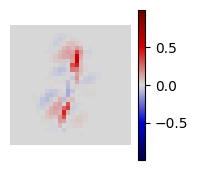

In [138]:
R = rel(0)

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = np.array(R[l][point_i])
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean())
    tut_utils.heatmap(dat.sum(axis=0), 0.5*i+1.5, 0.5*i+1.5, colorbar=True)

#### Batched visualization

shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0475, 0.0163, 0.0454, 0.0377, 0.0430, 0.0337])


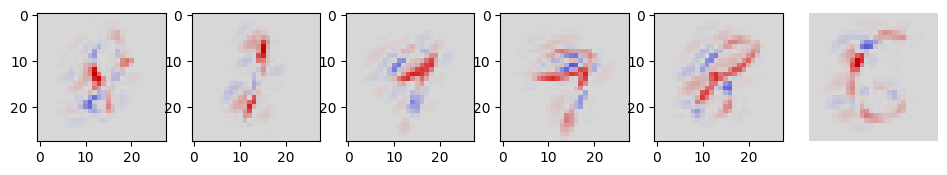

In [142]:
R = rel(0)

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = R[l][:6]
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
    tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0449, 0.0151, 0.0434, 0.0357, 0.0410, 0.0317])


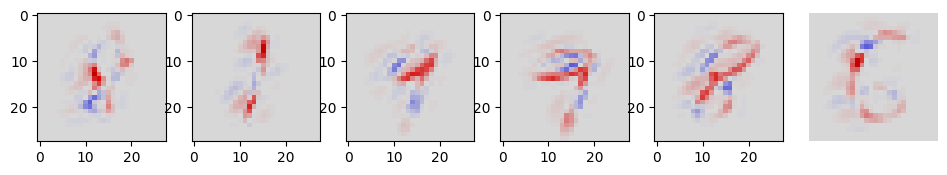

In [140]:
R = rel(1)

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = R[l][:6]
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
    tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0037, 0.0016, 0.0031, 0.0029, 0.0026, 0.0027])


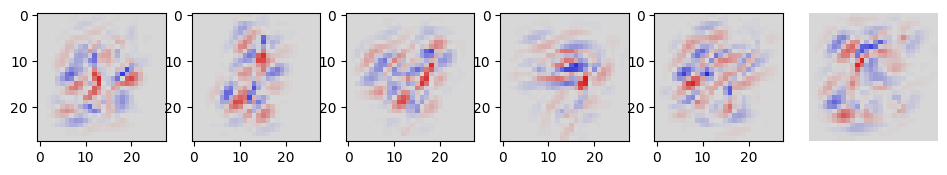

In [141]:
R1, R2 = rel(0), rel(1)

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = R1[l][:6] - R2[l][:6]
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
    tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

# Quantus Pixelflipping implementation

In [21]:
from quantus.helpers import utils
from copy import deepcopy
import pickle

def batch_auc(batch):
    return [utils.calculate_auc(np.array(curve)) for curve in batch]
def batch_mean_auc(batch):
    return np.mean(batch_auc(batch))

In [16]:
a_batch = A[0].detach().numpy() # get LRP-0 relevancies
batch_size = len(a_batch)

x_batch = data                                          .detach().numpy().reshape(a_batch.shape)
y_batch = A[-1].reshape((batch_size, -1)).argmax(axis=1).detach().numpy()

assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch]]
print(x_batch.shape, y_batch.shape, a_batch.shape)

(100, 1, 28, 28) (100,) (100, 1, 28, 28)


In [ ]:
pixFlipMetric = quantus.PixelFlipping(disable_warnings = False, perturb_baseline='black')

def flipScores(a_batch, k=None):
    if k==None: k=len(a_batch)
    return pixFlipMetric(
        model=model,
        x_batch=x_batch[:k],
        y_batch=y_batch[:k],
        a_batch=a_batch[:k],
        device=device
    )

mode_list = modes.values()
mode_list = ['LRP-0', 'Gamma. l<12 gamma=0.125', 'Gamma. l<12 gamma=0.25', 'Gamma. l<12 gamma=0.5', 'Gamma. l<12 gamma=inf']

model.eval()
batch_scores = { mode_str: { 'PixFlip': flipScores(rel(mode_str)[0].numpy()) } for mode_str in tqdm(modes.values()) }


Warnings and information:
 (1) The Pixel Flipping metric is likely to be sensitive to the choice of baseline value 'perturb_baseline'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bach, Sebastian, et al. 'On pixel-wise explanations for non-linear classifier decisions by layer - wise relevance propagation.' PloS one 10.7 (2015) e0130140.
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



  0%|          | 0/127 [00:00<?, ?it/s]

In [224]:
save_data('d3', 'PixFlipScores_gamma_0_1_21_inf', batch_scores)

### Load data and calculate statistics

In [ ]:
# batch_scores = load_data('d3', 'PixFlipScores_gamma_0_1_21_inf')

In [45]:
if False:
    experiment_dict = deepcopy(batch_scores)
else: # unfortunately I made a mistake. The Pix Flip scores are computed wrt. the correct class "taget", but the explanations are for the predicted class "y_batch". Mask out those where this is not equal.
    correction_mask = (target.detach().numpy() == y_batch)
    print("Fraction of useful scores:", correction_mask.mean())
    
    experiment_dict={}
    for mode_str in tqdm(batch_scores.keys()):
        methods = list(batch_scores[mode_str].keys())
        for method in methods:
            experiment_dict[mode_str] = {}
            experiment_dict[mode_str][method] = np.array(batch_scores[mode_str][method])[correction_mask]

Fraction of useful scores: 0.95


  0%|          | 0/127 [00:00<?, ?it/s]

In [47]:
for mode_str in tqdm(experiment_dict.keys()):
    methods = list(experiment_dict[mode_str].keys())
    for method in methods:
        if 'AUC' in method: continue
        experiment_dict[mode_str][method + ' AUC (per sample)'] =      batch_auc(experiment_dict[mode_str][method])
        experiment_dict[mode_str][method + ' AUC (batch mean)'] = batch_mean_auc(experiment_dict[mode_str][method])

    experiment_dict[mode_str]['Layerwise Relevancies'] = relevancies_per_mode[mode_str]
    
experiment_dict['x_batch'] = x_batch
experiment_dict['y_batch'] = y_batch

  0%|          | 0/127 [00:00<?, ?it/s]

In [26]:
experiment_dict.keys(), experiment_dict['LRP-0'].keys()

(dict_keys(['LRP-0', 'Gamma. l<3 gamma=0.05', 'Gamma. l<3 gamma=0.1', 'Gamma. l<3 gamma=0.15', 'Gamma. l<3 gamma=0.2', 'Gamma. l<3 gamma=0.25', 'Gamma. l<3 gamma=0.3', 'Gamma. l<3 gamma=0.35', 'Gamma. l<3 gamma=0.4', 'Gamma. l<3 gamma=0.45', 'Gamma. l<3 gamma=0.5', 'Gamma. l<3 gamma=0.55', 'Gamma. l<3 gamma=0.6', 'Gamma. l<3 gamma=0.65', 'Gamma. l<3 gamma=0.7', 'Gamma. l<3 gamma=0.75', 'Gamma. l<3 gamma=0.8', 'Gamma. l<3 gamma=0.85', 'Gamma. l<3 gamma=0.9', 'Gamma. l<3 gamma=0.95', 'Gamma. l<3 gamma=1.0', 'Gamma. l<3 gamma=inf', 'Gamma. l<5 gamma=0.05', 'Gamma. l<5 gamma=0.1', 'Gamma. l<5 gamma=0.15', 'Gamma. l<5 gamma=0.2', 'Gamma. l<5 gamma=0.25', 'Gamma. l<5 gamma=0.3', 'Gamma. l<5 gamma=0.35', 'Gamma. l<5 gamma=0.4', 'Gamma. l<5 gamma=0.45', 'Gamma. l<5 gamma=0.5', 'Gamma. l<5 gamma=0.55', 'Gamma. l<5 gamma=0.6', 'Gamma. l<5 gamma=0.65', 'Gamma. l<5 gamma=0.7', 'Gamma. l<5 gamma=0.75', 'Gamma. l<5 gamma=0.8', 'Gamma. l<5 gamma=0.85', 'Gamma. l<5 gamma=0.9', 'Gamma. l<5 gamma=0.95',

In [31]:
np.array(experiment_dict['LRP-0']['PixFlip AUC (per sample)']).shape

(100,)

In [48]:
aucs = np.zeros((len(d3_after_conv_layer), 95, len(gammas_0_1_21_inf), 1))

for i, l_leq in enumerate(d3_after_conv_layer):
    for j, g in enumerate(gammas_0_1_21_inf):
        if g!=0:
            mode_str = f'Gamma. l<{l_leq} gamma={g}'
        else: 
            mode_str = 'LRP-0'
            
        if mode_str not in experiment_dict.keys(): continue
        
        aucs[i, :, j, 0] = experiment_dict[mode_str]['PixFlip AUC (per sample)']

aucs.shape

(6, 95, 22, 1)

In [49]:
auc_means = np.zeros((len(d3_after_conv_layer), 1, len(gammas_0_1_21_inf), 1))

for i, l_leq in enumerate(d3_after_conv_layer):
    for j, g in enumerate(gammas_0_1_21_inf):
        if g!=0:
            mode_str = f'Gamma. l<{l_leq} gamma={g}'
        else: 
            mode_str = 'LRP-0'
            
        if mode_str not in experiment_dict.keys(): continue
        
        auc_means[i, 0, j, 0] = experiment_dict[mode_str]['PixFlip AUC (batch mean)']

auc_means.shape

(6, 1, 22, 1)

### Plot PixFlip performance

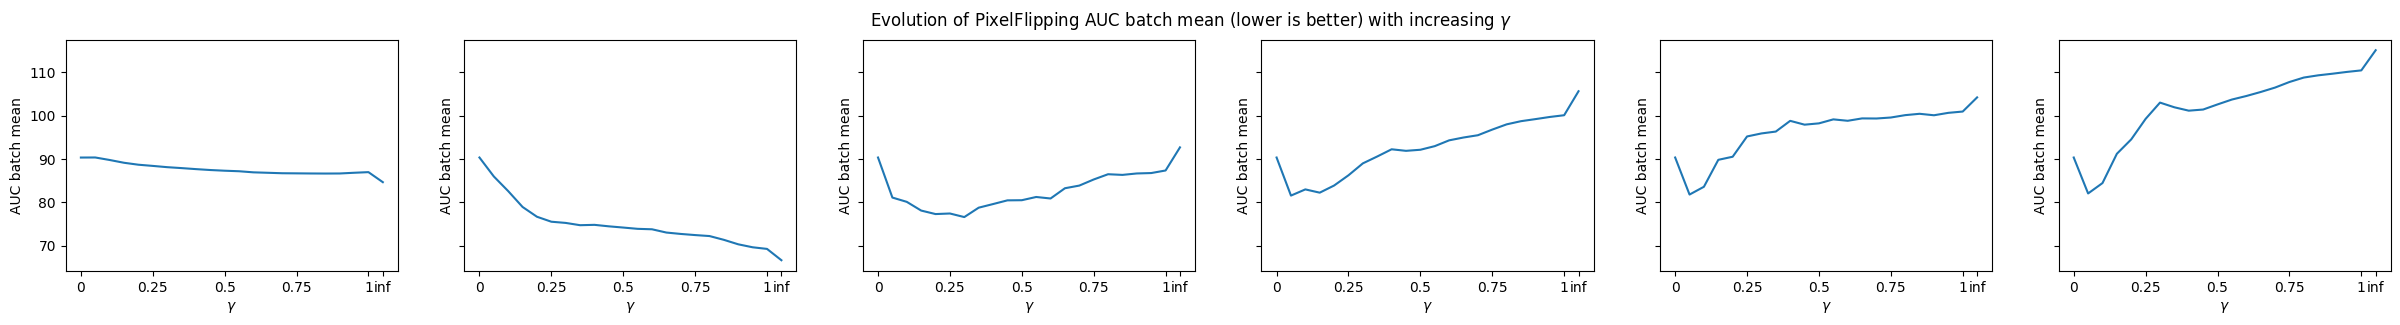

In [61]:
xtick_mask = np.zeros(len(gammas_0_1_21_inf)).astype(bool)
xtick_mask[[0, 5, 10, 15, 20, -1]] = True

plot_evals_lineplot(auc_means, gammas_0_1_21_inf, ylim=auc_means.max(), ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True, xtick_mask=xtick_mask)

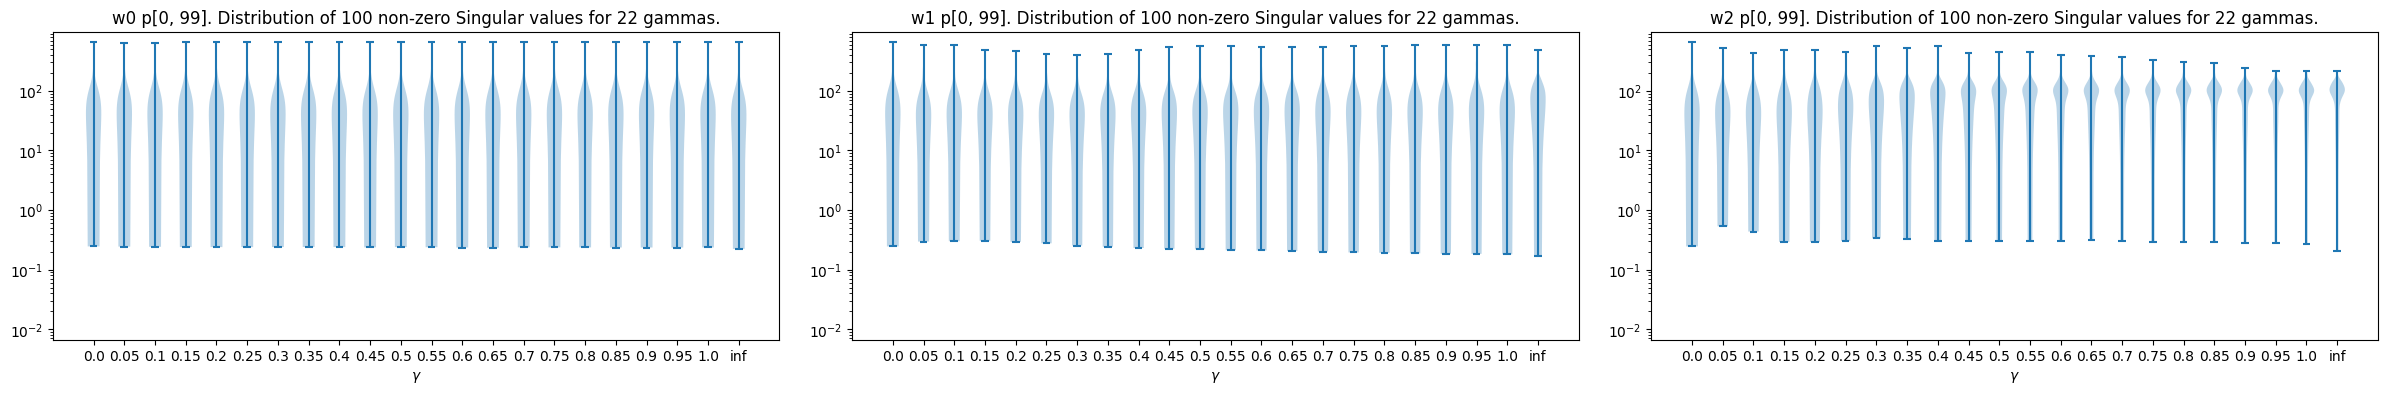

In [241]:
distribution_plot(aucs[[0,2,4]], gammas_0_1_21_inf, aggregate_over='points', mode='violin')

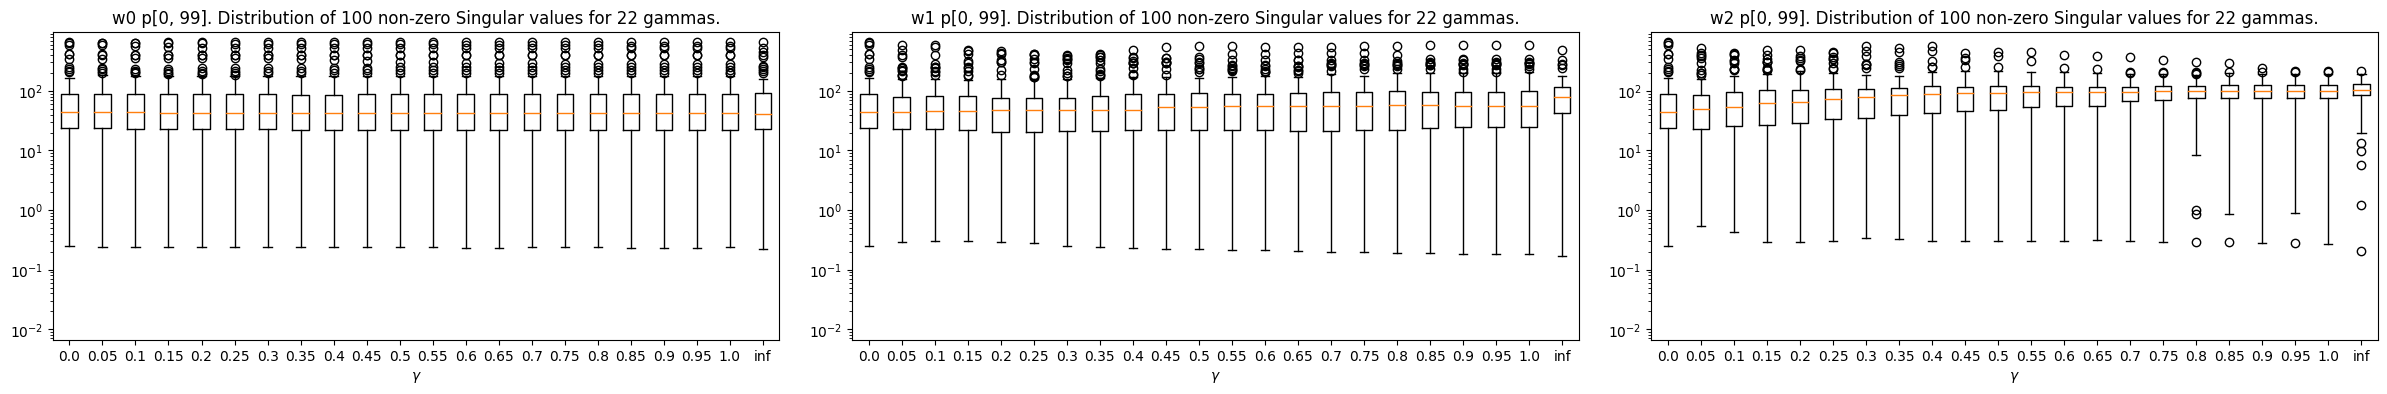

In [242]:
distribution_plot(aucs[[0,2,4]], gammas_0_1_21_inf, aggregate_over='points', mode='box')

### Plot individual PixFlipScores

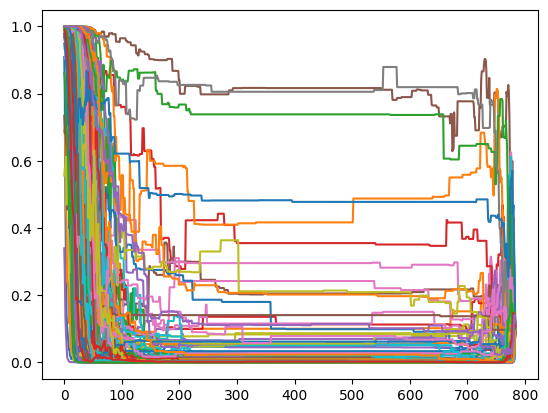

In [298]:
# pixel flip scores for LRP-0
scores = experiment_dict['LRP-0']['PixFlip']
scores = np.array(scores)
print(scores.shape)
plt.plot(scores.T);

(95, 784)


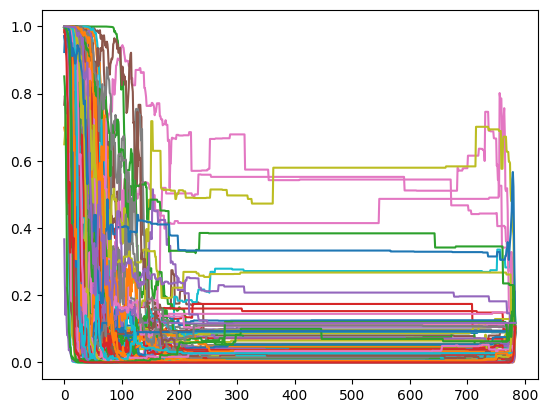

In [301]:
# pixel flip scores for Gamma. l<12 gamma=0.25
scores = experiment_dict['Gamma. l<12 gamma=0.25']['PixFlip']
scores = np.array(scores)
print(scores.shape)
plt.plot(scores.T);